#### 3. Depurar la base de datos.

- Esto puede incluir la eliminación de valores anómalos (error de entrada de datos), la imputación de valores perdidos y la transformación de variables.

In [189]:
import pandas as pd 
from tabulate import tabulate
import re
import numpy as np
import matplotlib.pyplot as plt

# Leemos el archivo de datos
dfAL = pd.read_csv('../data/rawdata/Alabama.csv', encoding="latin1") 
dfFL = pd.read_csv('../data/rawdata/Florida.csv', encoding="latin1")
dfMA = pd.read_csv('../data/rawdata/Massachusetts.csv', encoding="latin1")

# Concatenamos los datos
df = pd.concat([dfAL, dfFL, dfMA])

# Limpiamos los datos

# Eliminamos los valores nulos
df = df.dropna(subset=['Ageyears', 'Height_cm', 'Armspan_cm'])

# Función para limpiar rangos y texto
def clean_ranges_and_text(value: str):
    try:
        value = str(value)
    except:
        pass
    # Eliminar cualquier texto no numérico, como 'cm'
    value = re.sub(r'[^\d.-]', '', value)
    if not value:  # Manejar el caso donde la cadena queda vacía
        return None
    pattern = r"(\d+)-(\d+)"
    match = re.match(pattern, value)
    if match:
        return float(match.group(1))  # Devuelve el primer número en el rango como float
    return float(value)

# Aplicar la limpieza a las columnas 'Height_cm' y 'Armspan_cm'
df["Height_cm"] = df["Height_cm"].apply(clean_ranges_and_text)
df["Armspan_cm"] = df["Armspan_cm"].apply(clean_ranges_and_text)

# Convertir las columnas a tipo numérico
df["Height_cm"] = pd.to_numeric(df["Height_cm"], errors="coerce")
df["Armspan_cm"] = pd.to_numeric(df["Armspan_cm"], errors="coerce")
df["Ageyears"] = pd.to_numeric(df["Ageyears"], errors="coerce")

# Eliminamos nuevamente los valores nulos para que se eliminen los valores que no se pudieron convertir a numéricos
df = df.dropna(subset=['Ageyears', 'Height_cm', 'Armspan_cm'])

# Exportar el DataFrame limpio a un archivo CSV
df.to_csv('../data/cleandata/datasetcleaned.csv', index=False)


In [190]:
def Foot_to_centimeters(row):
    try:
        expresion = r"\d+"
        if type(row) is float:
            return row
        if ("'" in row) or ('"' in row) or ("/" in row):
            number = re.findall(expresion, row)
            if len(number) < 2:
                number = int(number[0])* 30.48
                return number
            number = int(number[0]) + int(number[1])/10
            number *= 30.48
            return number
        if ("cm" in row) or ("ft" in row):
            number = re.findall(expresion, row)
            return number[0]
        if "," in row and (len(re.findall(r"\d+", row)) == 2):
            number = re.findall(expresion, row)
            number = int(number[0]) + int(number[1])
            number *= 30.48
            return number
        try:

            number = float(row)
            return number
        except ValueError:
            print(f"No es un número decimal : {row}")
    except Exception as err:
        print(f"fake : {row}")
        print(err)

In [191]:
df.Height_cm = df.Height_cm.apply(Foot_to_centimeters)
df["Height_cm"] = df["Height_cm"].astype(float)
df.Armspan_cm = df.Armspan_cm.apply(Foot_to_centimeters)
df["Armspan_cm"] = df["Armspan_cm"].astype(float)

print(df[['Armspan_cm','Height_cm']].dtypes)
df.to_csv('../data/cleandata/datasetcleaned.csv', index=False)

Armspan_cm    float64
Height_cm     float64
dtype: object


----

### Imputación de Valores anómalos

Para la pregunta 2, fue necesario analizar la relación entre Height_cm y Armspan_cm, sin embargo, en una primera versión encontramos un comportamiento atípico. (Véase imágen 1)

<center><img src="../documentacion_errores/fail1.png">
<p>De manera que por eso nos regresamos a este proceso de limpieza para tratar esos valores atípicos</p></center>

Dado que la relación que existe entre la altura de una persona es un valor muy cercano al del largo de sus brazos de punta a punta, entonces empezamos a limpiar teniendo en cuenta que todos los datos que no cumplan esta condición, son anómalos.

In [192]:
dfraw = pd.read_csv('../data/cleandata/datasetcleaned.csv', encoding="latin1")

Lo primero que nos preguntamos fue ¿Por qué hay valores tan bajos en el eje de Estatura? ¿Realmente estamos trabajando con personas que miden 90 cm de alto?

In [193]:
print("Edad mínima: ", dfraw['Ageyears'].min())
print("Edad máxima: ", dfraw['Ageyears'].max())

Edad mínima:  7.0
Edad máxima:  99999.0


Esto en primer lugar fue extraño, está bien que la edad mínima sea 10. Pero definitivamente en la edad máxima había un error. Así que vamos a graficarlo para corroborar

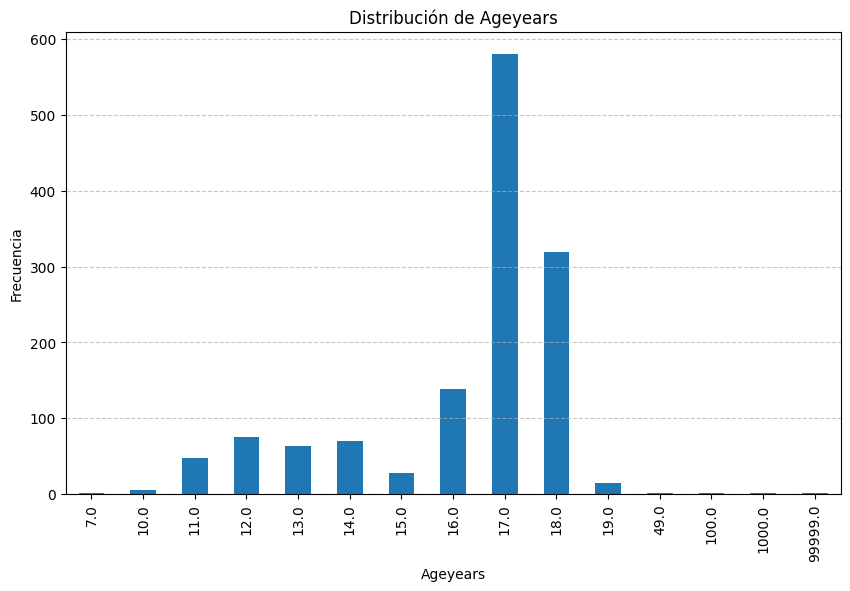

In [194]:
dfraw['Ageyears'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
plt.title('Distribución de Ageyears')
plt.xlabel('Ageyears')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)

Procederemos a eliminar el valor atípico que podemos observar en la gráfica

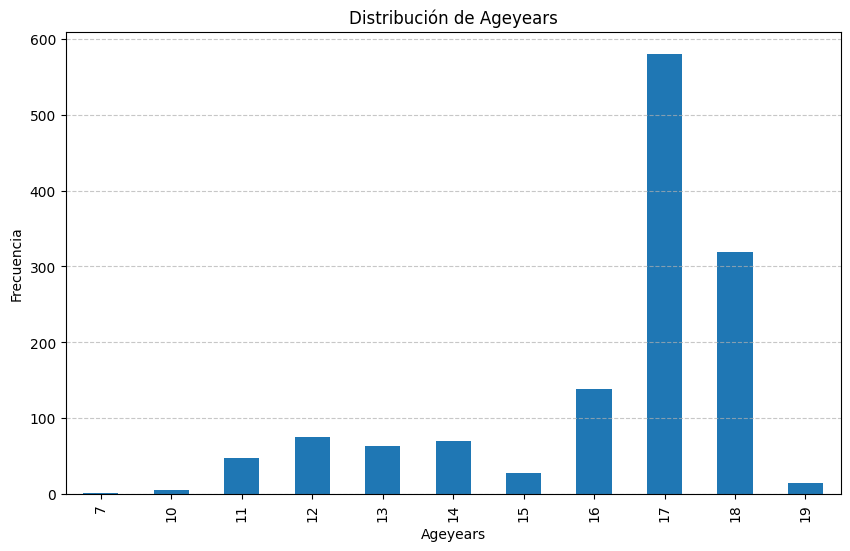

In [195]:
dfraw = dfraw[dfraw['Ageyears'] <= 20] # Filtrar los datos para excluir el valor 9999.0 en 'Ageyears'
dfraw['Ageyears'] = np.ceil(dfraw['Ageyears']).astype(int)# Redondear hacia arriba los valores de 'Ageyears' y convertirlos a enteros

dfraw['Ageyears'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))# Crear la gráfica de barras para 'Ageyears'
plt.title('Distribución de Ageyears')
plt.xlabel('Ageyears')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

dfraw.to_csv('../data/cleandata/datasetcleaned.csv', index=False) # Guardamos los cambios

Ahora que sabemos que estamos hablando de personas entre 10 y 19 años, volvamos a revisar el rango de estatura tiendo en cuenta esa información presente

In [196]:
print("Altura mínima: ", dfraw['Height_cm'].min())
print("Altura máxima: ", dfraw['Height_cm'].max())

Altura mínima:  1.63
Altura máxima:  5000.0


Vamos a cruzar información. En este articulo de la <a href="https://www.stanfordchildrens.org/es/topic/default?id=normal-growth-90-P04728">Standford Medicine</a> sobre le crecimiento normal. Tenemos que los niñ@s a los 11 años se encuentran en una rango de altura entre los 127cm y 149cm para las chicas y 128cm y 149cm para los chicos, de manera que con esta información, ya sabemos un límite mínimo, que resulta en que si las personas más jóvenes tiene 10 años, entonces su altura debe estar por encima de aprox 127cm.

In [197]:
dfraw = dfraw[dfraw['Height_cm'] > 127] # Filtrar los datos para excluir valores menores a 127 en 'Height_cm'

Ahora nos preguntamos: ¿Es normal que personas entre 11 y 19 años tengan un rango de estatura entre 1.26cm y 5000cm? <br>
No, eso no tiene sentido. De manera que identificamos que los valores de altura se encuentran atípicos, la verdadera pregunta es ¿Cómo los estandarizamos? <br>
<blockquote>- "Datos numéricos: La imputación con la media es más apropiada para datos numéricos en una escala de medición continua o al menos ordinal. No se debe aplicar a variables categóricas o nominales, ya que la media carece de significado en estos casos."</blockquote> <br>Ver más información en sobre la imputación de datos con la media en este foro de <a href="https://nicolasurrego.medium.com/tratamiento-de-valores-vac%C3%ADos-ii-estrategias-de-imputaci%C3%B3n-estad%C3%ADstica-moda-mediana-y-media-2665b0f53a4c">Medium</a>

De manera que, ¿Cómo y cúando podemos realizar la imputación de datos con la media en este ejemplo?. <br>Volviendo con la tesis de que la altura de las personas es muy similar a la longitud de brazo a brazo (braza). <br>Podemos realizar lo siguiente: 
1. Hallar la diferencia entre la altura y la braza de cada persona.
2. Con ese valor hallado, podemos identificar qué tanto se acerca o se aleja para cumplir con la condición de que sean equivalentes, lo que en otras palabras significa que, entre más lejos esté la diferencia de 1, más atípico es ese dato.
3. Con esos valores hallados, podemos entonces identificar qué datos podemos amputar con la media, de manera que todo registro que tenga valores atípicos en la Altura y en la Braza, serán imputados con el promedio de dicha variable.

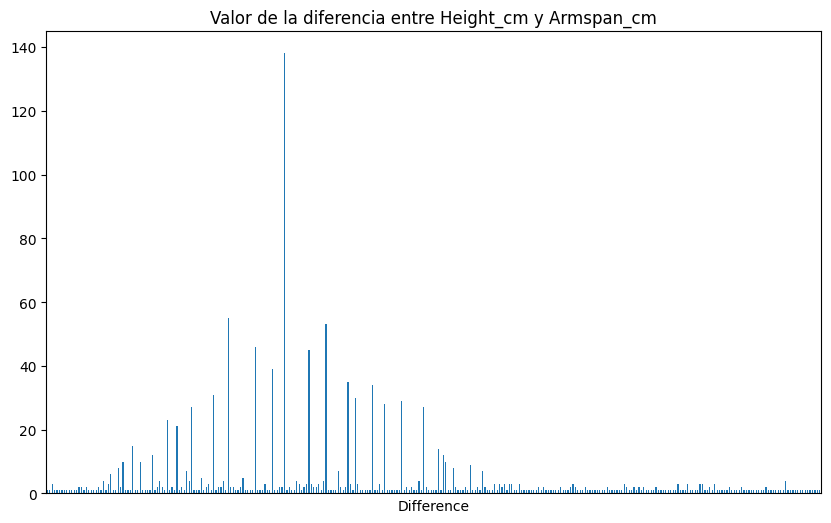

In [198]:
# Calcular la diferencia entre 'Height_cm' y 'Armspan_cm' y agregarlo como una nueva columna
dfraw['Difference'] = dfraw['Height_cm'] - dfraw['Armspan_cm']

# Mostrar las diferencias de los valores a lo largo de todos los registros
dfraw['Difference'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
plt.xticks([])
plt.title('Valor de la diferencia entre Height_cm y Armspan_cm')
plt.show()

Estos registros que tienen valores tan altos, son los registros que hemos identificado como atípicos, ya que estamos hablando que a mayor sea el valor de la dferencia de medidas entre la altura y la braza, mayor es el error que representa ese registro. Bajo este orden de ideas, serán esos datos a los que realizaremos la imputación por medias. <br>Para esto, usaremos un margen de diferencia preestablecido, es decir, consideraremos en el análisis aquellos datos que tienen una diferencia entre la braza y la altura de 10cm

In [199]:
# Ordenar el DataFrame por la columna 'Difference' de mayor a menor
dfraw = dfraw.sort_values(by='Difference', ascending=False)
# Margen 
margen = 10

# Calcular las medias de las columnas 'Height_cm' y 'Armspan_cm'
meanheight = dfraw['Height_cm'].mean()
meanarms = dfraw['Armspan_cm'].mean()

# Reemplazar valores en 'Armspan_cm' y 'Height_cm' cuando 'Difference' es mayor a 10 o menor a -10
mask = (dfraw['Difference'] > margen) | (dfraw['Difference'] < -margen)
dfraw.loc[mask, 'Armspan_cm'] = meanarms
dfraw.loc[mask, 'Height_cm'] = meanheight

dfraw.to_csv('../data/cleandata/datasetcleaned.csv', index=False) # Guardamos los cambios

<center><p>Con estos arreglos, el gráfico de "La relación entre al altura y la distancia de los brazos extendidos" quedó así:
</p><img src="../documentacion_errores/finalplot1.png">
</center>

----